In [1]:
import sys

import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

sys.path.append("../..")
import numpy as np
import tensorflow as tf
from Bio import SeqIO

import evoten

2025-11-14 15:37:51.268862: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763131071.285758 2572396 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763131071.290939 2572396 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763131071.307819 2572396 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763131071.307850 2572396 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763131071.307853 2572396 computation_placer.cc:177] computation placer alr

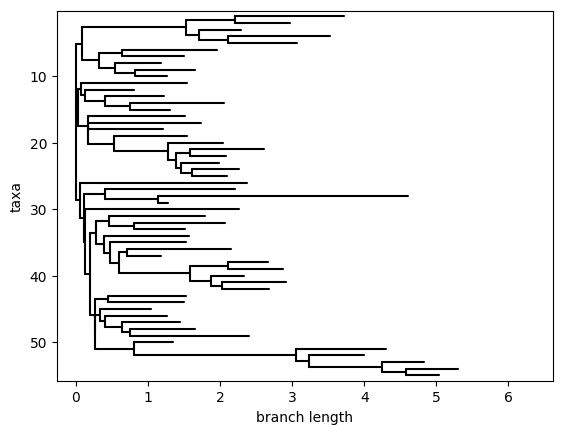

In [2]:
tree_file = "../data/PF00028.fasta.raxml.bestTree"
tree_handler = evoten.TreeHandler.read(tree_file)
tree_handler.draw(no_labels=True)

In [3]:
msa_file = "../data/PF00028_gen.fa"
# sequences generated with above tree
!head {msa_file}

>CADH5_HUMAN/263-364
DIPSA------------GNVFKSA----GRNTGP----A----------GIAS--AP-----GG----------------LRKEPV-L--V-VLQA--RIT-LLSSLL-SE---VAQLYE-DGWAA-KRDVSD--T--LY----L--DV---ELVGSVLKEKK----VFAIGMPF----LLPVLK--------------LQA------DG--QVIYNGT-R-R--------DHLSAC-----------CYFKGG---V----EGLK-CGALPK--SGKTTY-----GVH--VSEFLYRHTNFC--LV-KSDYLLESNSRDIWGI-----------NYVLNGN--IAVNGEDF--WENKILKAYEEPEN----LVTNEGMET---M-RKYAHR-EDEAED---------I-GASFMLLEE-CPK-------------------------------GAQ---FRQ-----LFKTTIAIARA--TSAGAV---IDMFLPP-V--P------IS--VNRHKKAFLQKIPNCT-GL-----------VYDKADNVNNTTFPSYEGD-I---GREFA---VTAD----R-------NASSR-G--H-WWMA------LENKH---EI--LTDKAQ---C--D----RGGH-E---S------GRHLF---IPKPTWRT--------------AINLAVGGYL--LKDR-ES--R-AGDHMR------HEP-FGSNLTP---SA-------------IGV--YQRAK--YMGDVLQTVKWLLKNVRS-----PR--IDHELHN---------DQT--R-----GTIDGPTV--HALNGSGRV-H---L----------QDP-DKQWPVSAPGL----------AISE-----------RG--SYEHSVFIAIDEFLGRYPDVMGHFPL----DKSPL--II--------------------------------S--G-------H-

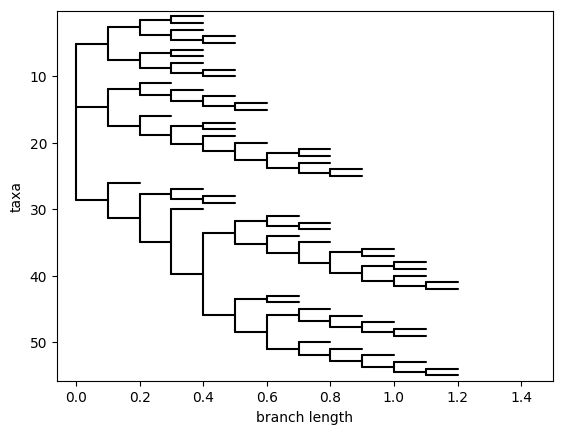

In [4]:
# make a tree with the same topology but with uniform branch lengths
initial_branch_length = 0.1
unit_tree_handler = evoten.TreeHandler.copy(tree_handler)
unit_tree_handler.set_branch_lengths(
    np.ones_like(tree_handler.branch_lengths) * initial_branch_length
)
unit_tree_handler.draw(no_labels=True)

In [5]:
# parse fasta
import evoten.model

alphabet = "ARNDCQEGHILKMFPSTWYV-"

leaf_names = []
seqs = []
for record in SeqIO.parse(msa_file, "fasta"):
    leaf_names.append(record.id)
    seqs.append(str(record.seq))

one_hot_leaves = evoten.util.encode_one_hot(seqs, alphabet=alphabet)

# only learn on dense columns
sparse_columns = np.mean(one_hot_leaves[..., -1], axis=0) > 0.8
one_hot_leaves = one_hot_leaves[:,~sparse_columns]
one_hot_leaves = np.reshape(
    one_hot_leaves, 
    (one_hot_leaves.shape[0], 
     1,
     -1,
     one_hot_leaves.shape[-1])
)

#replace gaps with ones
one_hot_leaves[one_hot_leaves[..., -1] == 1] = 1
one_hot_leaves = one_hot_leaves[..., :-1] # remove gap dimension

one_hot_leaves.shape

(55, 1, 1990, 20)

In [6]:
conservation = np.max(np.mean(one_hot_leaves, axis=0), axis=-1)
np.argwhere(conservation[0] > 0.9).flatten()

array([], dtype=int64)

In [7]:
print("MSA depth:", len(seqs))
print("MSA width:", len(seqs[0]))
print("Tree height:", unit_tree_handler.height)
print("Tree nodes:", unit_tree_handler.num_nodes)

MSA depth: 55
MSA width: 4054
Tree height: 12
Tree nodes: 108


In [8]:
num_models = 1

# add length dimension
branch_lengths = unit_tree_handler.branch_lengths[..., np.newaxis].astype(np.float32)
branch_lengths.shape

(107, 1, 1)

In [9]:
evoten.set_backend("tensorflow")

In [10]:
exchangeability_matrix, _ = evoten.substitution_models.jukes_cantor(
    d = len(alphabet)-1
)
# add node and length dimensions
exchangeability_matrix = exchangeability_matrix[np.newaxis, :, np.newaxis,...] 

In [ ]:
import tensorflow as tf
import numpy as np
from evoten.expm_gtr import precompute_gtr, expm_gtr_from_decomp

class LikelihoodGivenTreeModel(tf.keras.Model):
    """Optimizes the parameters (but not the topology) of a tree,
    using precomputed GTR decomposition to avoid XLA issues.
    """

    def __init__(
        self,
        tree_handler,
        exchangeability_matrix: np.ndarray,
        branch_lengths: np.ndarray,
        equilibrium_frequencies: np.ndarray,
        train_rate_matrix: bool = False,
        train_branch_lengths: bool = True,
        train_equilibrium_frequencies: bool = False,
        name: str = "LikelihoodGivenTreeModel",
        **kwargs
    ):
        super().__init__(name=name, **kwargs)

        self.tree_handler = tree_handler

        # Initial parameters
        self.branch_lengths = branch_lengths.astype(np.float32)
        self.branch_lengths_init = evoten.backend.inverse_softplus(self.branch_lengths).numpy()

        self.exchangeability_matrix = exchangeability_matrix.astype(np.float32)
        self.exchangeability_matrix_init = tf.convert_to_tensor(
            evoten.backend.inverse_softplus(self.exchangeability_matrix), dtype=tf.float32
        )

        self.equilibrium_frequencies = equilibrium_frequencies.astype(np.float32)
        self.equilibrium_frequencies_init = tf.math.log(
            tf.convert_to_tensor(self.equilibrium_frequencies, dtype=tf.float32)
        )

        self.train_rate_matrix = train_rate_matrix
        self.train_branch_lengths = train_branch_lengths
        self.train_equilibrium_frequencies = train_equilibrium_frequencies

        # Precompute decomposition (fixed batch of size 1 for now)
        self._gtr_decomp = precompute_gtr(
            self.make_exchangeability_matrix().numpy(),
            self.make_equilibrium_frequencies().numpy()
        )

    def build(self, input_shape=None):
        # Branch lengths
        self.branch_lengths_kernel = self.add_weight(
            shape=self.branch_lengths.shape,
            initializer=tf.constant_initializer(self.branch_lengths_init),
            trainable=self.train_branch_lengths,
            name="branch_lengths_kernel",
        )

        super().build(input_shape)

    # ---- Parameter getters ----
    def make_branch_lengths(self):
        return evoten.backend.make_branch_lengths(self.branch_lengths_kernel)

    def make_equilibrium_frequencies(self):
        return evoten.backend.make_equilibrium(self.equilibrium_frequencies_init)

    def make_exchangeability_matrix(self):
        return evoten.backend.make_symmetric_pos_semidefinite(
            self.exchangeability_matrix_init
        )

    def make_rate_matrix(self, equilibrium_frequencies=None):
        eq = equilibrium_frequencies if equilibrium_frequencies is not None else self.make_equilibrium_frequencies()
        return evoten.backend.make_rate_matrix(
            self.make_exchangeability_matrix(),
            eq
        )

    # ---- Likelihood computation using precomputed decomposition ----
    def loglik(self, inputs):
        branch_lengths = self.make_branch_lengths()
        eq_freqs = self.make_equilibrium_frequencies()
        Q = self.make_rate_matrix(eq_freqs)

        # Use precomputed GTR decomposition; recompute only if trainable
        transition_probs = expm_gtr_from_decomp(self._gtr_decomp, branch_lengths)

        return evoten.model.loglik(
            inputs,
            self.tree_handler,
            transition_probs,
            self.equilibrium_frequencies_init,
            leaf_names=getattr(self.tree_handler, "leaf_names", None)
        )

    def call(self, inputs):
        return self.loglik(inputs)

    def compute_loss(self, x, y, y_pred, sample_weight=None):
        # average over models and sum over sequence length
        y_pred = tf.reduce_mean(y_pred, axis=0)
        y_pred = tf.reduce_sum(y_pred)
        return -y_pred


In [31]:
equilibrium_frequencies = np.ones(
    (num_models, 1, len(alphabet)-1)) / len(alphabet
)
print("exchangeability_matrix shape:", exchangeability_matrix.shape)
print("branch_lengths shape:", branch_lengths.shape)
print("equilibrium_frequencies shape:", equilibrium_frequencies.shape)
model = LikelihoodGivenTreeModel(
    unit_tree_handler,
    exchangeability_matrix=exchangeability_matrix,
    branch_lengths=branch_lengths,
    equilibrium_frequencies=equilibrium_frequencies,
    train_rate_matrix=False,
    train_branch_lengths=True,
    train_equilibrium_frequencies=False,
)

exchangeability_matrix shape: (1, 1, 1, 20, 20)
branch_lengths shape: (107, 1, 1)
equilibrium_frequencies shape: (1, 1, 20)


AttributeError: 'GTRDecomp' object has no attribute 'numpy'

In [32]:
model.build()

ValueError: You cannot add new elements of state (variables or sub-layers) to a layer that is already built. All state must be created in the `__init__()` method or in the `build()` method.

Text(0.5, 1.0, 'Initial rate matrix')

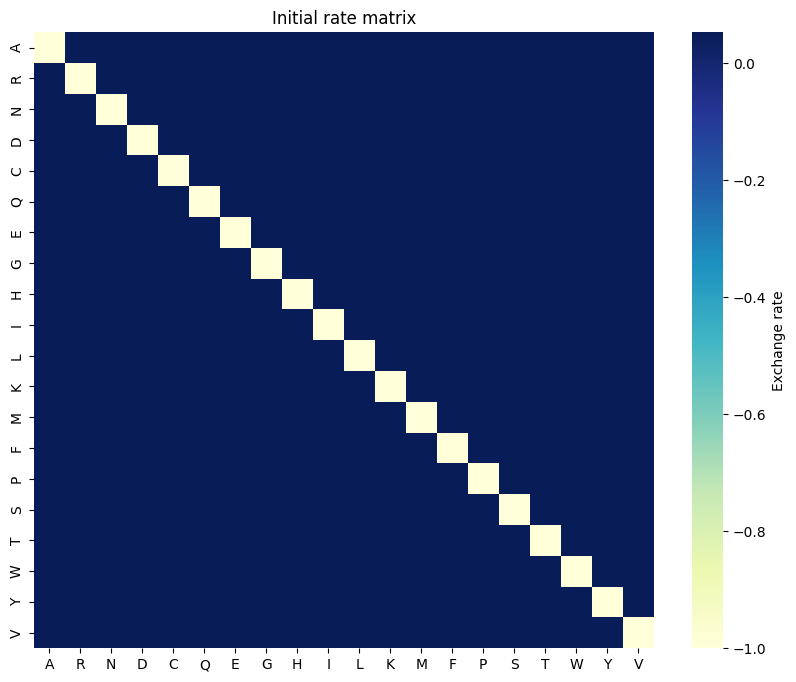

In [27]:
initial_rate_matrix = model.make_rate_matrix()[0,0,0]
# make a heatmap from above 20x20 matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.heatmap(
    initial_rate_matrix,
    xticklabels=alphabet[:-1],
    yticklabels=alphabet[:-1],
    cmap="YlGnBu",
    cbar_kws={"label": "Exchange rate"},
).set_title("Initial rate matrix")

In [28]:
model(one_hot_leaves)

<tf.Tensor: shape=(1, 1990), dtype=float32, numpy=
array([[106.35719 , 106.490944, 109.44745 , ...,        inf, 109.651566,
        109.57785 ]], dtype=float32)>

In [29]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-1)
# disable jit_compile otherwise the matrix exponential gradient will fail
model.compile(optimizer, jit_compile=True)
model.fit(
    one_hot_leaves,
    batch_size=one_hot_leaves.shape[0],
    epochs=100,
    verbose=0,
    shuffle=False
)
# plot the loss
import matplotlib.pyplot as plt
plt.plot(model.history.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("NLogLikelihood")
plt.title("NLogLikelihood vs Epoch")
plt.show()

/home/felix/miniforge3/envs/learnMSAdev/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")
E0000 00:00:1763131139.996545 2572565 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0000 00:00:1763131140.018871 2572565 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible wi

FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/felix/miniforge3/envs/learnMSAdev/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/felix/miniforge3/envs/learnMSAdev/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/felix/miniforge3/envs/learnMSAdev/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/felix/miniforge3/envs/learnMSAdev/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 211, in start

  File "/home/felix/miniforge3/envs/learnMSAdev/lib/python3.12/asyncio/base_events.py", line 645, in run_forever

  File "/home/felix/miniforge3/envs/learnMSAdev/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once

  File "/home/felix/miniforge3/envs/learnMSAdev/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/felix/miniforge3/envs/learnMSAdev/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/felix/miniforge3/envs/learnMSAdev/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/felix/miniforge3/envs/learnMSAdev/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/felix/miniforge3/envs/learnMSAdev/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/felix/miniforge3/envs/learnMSAdev/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/felix/miniforge3/envs/learnMSAdev/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/felix/miniforge3/envs/learnMSAdev/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/felix/miniforge3/envs/learnMSAdev/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3100, in run_cell

  File "/home/felix/miniforge3/envs/learnMSAdev/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3155, in _run_cell

  File "/home/felix/miniforge3/envs/learnMSAdev/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/felix/miniforge3/envs/learnMSAdev/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3367, in run_cell_async

  File "/home/felix/miniforge3/envs/learnMSAdev/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3612, in run_ast_nodes

  File "/home/felix/miniforge3/envs/learnMSAdev/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3672, in run_code

  File "/tmp/ipykernel_2572396/1308918816.py", line 4, in <module>

  File "/home/felix/miniforge3/envs/learnMSAdev/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/felix/miniforge3/envs/learnMSAdev/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit

  File "/home/felix/miniforge3/envs/learnMSAdev/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function

  File "/home/felix/miniforge3/envs/learnMSAdev/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_4812]

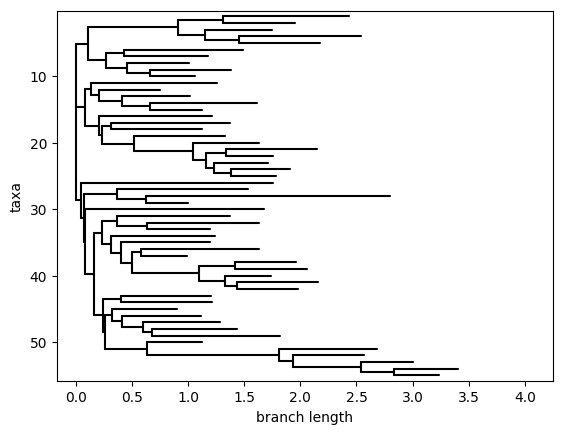

In [ ]:
optimized_tree_handler = evoten.TreeHandler.copy(tree_handler)
optimized_tree_handler.set_branch_lengths(model.make_branch_lengths()[...,-1].numpy())
optimized_tree_handler.draw(no_labels=True)

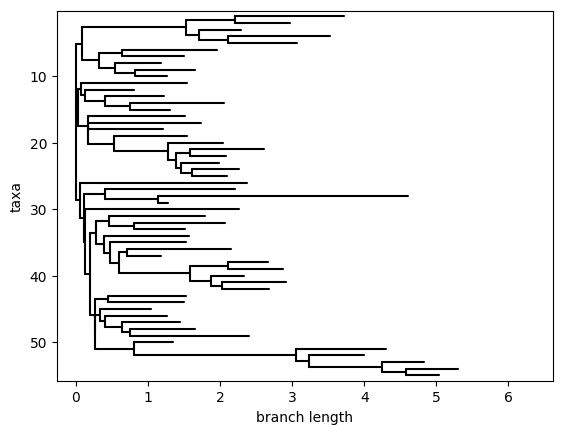

In [ ]:
tree_handler.draw(no_labels=True)

Text(0.5, 1.0, 'Learned rate matrix')

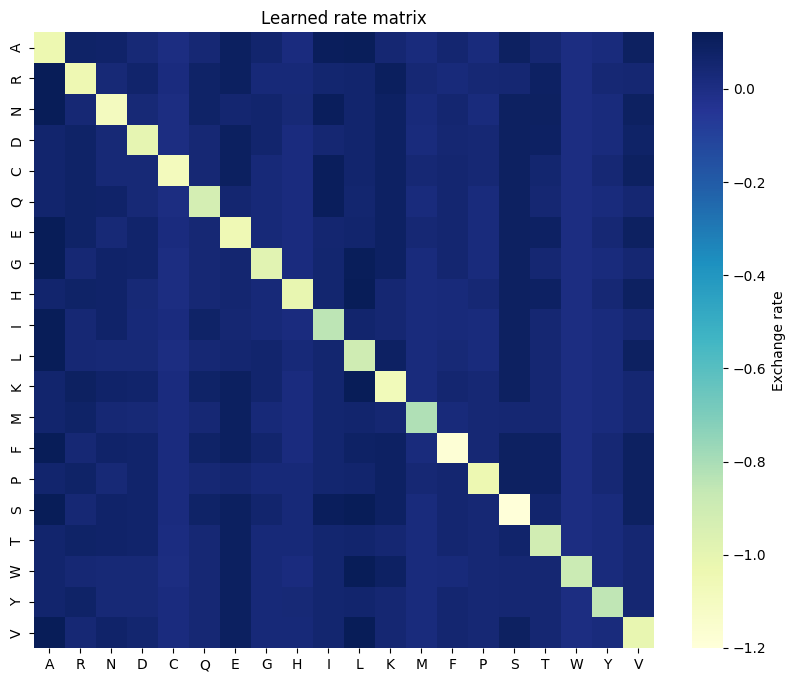

In [ ]:
learned_rate_matrix = model.make_rate_matrix()[0,0,0]
# make a heatmap from above 20x20 matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.heatmap(
    learned_rate_matrix,
    xticklabels=alphabet[:-1],
    yticklabels=alphabet[:-1],
    cmap="YlGnBu",
    cbar_kws={"label": "Exchange rate"},
).set_title("Learned rate matrix")

Text(0.5, 1.0, 'LG rate matrix')

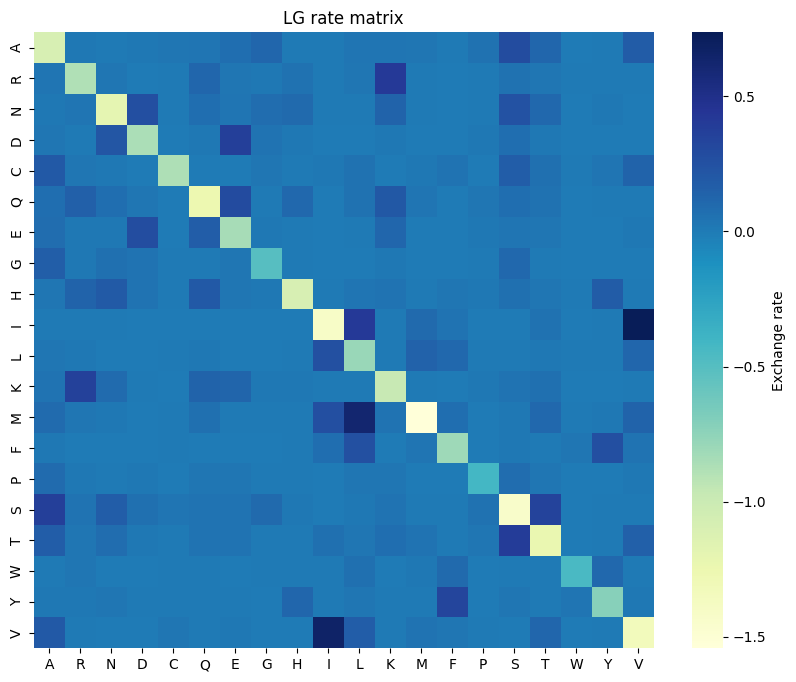

In [ ]:
R, pi = evoten.substitution_models.LG()
LG_rate_matrix = evoten.backend.make_rate_matrix(R, pi)
plt.figure(figsize=(10, 8))
sns.heatmap(
    LG_rate_matrix,
    xticklabels=alphabet[:-1],
    yticklabels=alphabet[:-1],
    cmap="YlGnBu",
    cbar_kws={"label": "Exchange rate"},
).set_title("LG rate matrix")